**rajvi using steph's code**

In [247]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium

In [248]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [249]:
api = MapboxAPI()

In [250]:
response = api.get_data((41.97557881655979, -87.71361314512697), 15)
#response

In [251]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

#for i in range(branchRadii.shape[0]):
#    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 5)
#    branchRadii.loc[i,'geometry'] = shape(api_response)

api_response = api.get_data((branchRadii.loc[0,'LATITUDE'],branchRadii.loc[0,'LONGITUDE']), 5)
branchRadii.loc[0,'geometry'] = shape(api_response)

/tmp/ipykernel_1509437/1050654561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_1509437/1050654561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


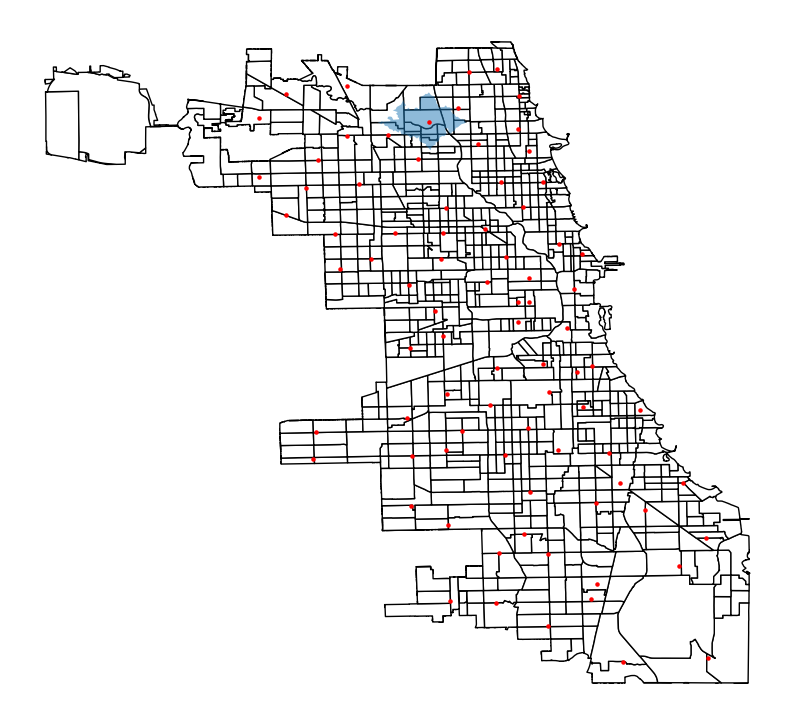

In [252]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    #crs="epsg:4326",
    crs="epsg:32633",
    )

#branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly.crs = 'EPSG:32633'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

#branchRadii = branchRadii.set_crs('epsg:4326')
branchRadii = branchRadii.set_crs('epsg:32633')

branchLocsOnly = gpd.GeoDataFrame(
    #branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:32633")

fig, ax = plt.subplots(1, figsize=(10, 10))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

In [178]:
#print(branchRadii.crs)
#print(branchRadii.area/10**6)
#branchRadii.head(5)

In [273]:
albanyPark=pd.DataFrame
albanyPark = pd.DataFrame(columns=['Census Tract','geometry'])
areaCalculations = pd.DataFrame(columns=['Census Tract','geometry', 'area'])
albanyPark.reset_index(inplace = True)

# for loop to make dataframe of overlapping census tracts with the names of each census tract and polygon of area covered
# for loop also adds to new data frame which is collecting the name and geometry of the entire census tract that is partially or fully covered by
# the radius

for index, row in censusTracts.iterrows():
    if ((branchRadii.intersection(row['geometry']))[0]).is_empty:
        empty=[]
        empty.append("none")
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(branchRadii.intersection(row['geometry'])[0])]}, index=[0])
        albanyPark=pd.concat([albanyPark,temp])
        areaTemp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(row['geometry'])]})
        areaCalculations = pd.concat([areaCalculations, areaTemp])
        
# convert albanyPark to geodata frame and reasssign to crs used for area calculations (by default, its 4326 geometries)
albanyPark = gpd.GeoDataFrame(albanyPark, crs="epsg:4326")
albanyPark= albanyPark.to_crs('epsg:32633')

albanyPark.reset_index(inplace = True)
albanyPark=albanyPark.drop(['level_0', 'index'], axis=1)
albanyPark["Area Within Radius"] = albanyPark['geometry'].area/ 10**6

def tractArea(row):
    for index, tracts in censusTracts.iterrows():
        if row['Census Tract'] == tracts['geoid']:
            return (tracts['current land area (sq. m)']+tracts['current water area (sq. m)'])/ 10**6
            #return tracts.area/ 10**6

albanyPark['Tract Area']= albanyPark.apply(tractArea, axis=1)
albanyPark['Percent Overlap'] = albanyPark['Area Within Radius']/albanyPark['Tract Area']*100
albanyPark

/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


,Census Tract,geometry,Area Within Radius,Tract Area,Percent Overlap
0,17031140800,"POLYGON ((-5362723.304 11526358.296, -5362651....",0.166430,0.725873,22.928301
1,17031160501,"POLYGON ((-5363389.242 11527528.859, -5363674....",0.050482,0.345248,14.622085
2,17031140702,"POLYGON ((-5363271.129 11527810.079, -5363172....",0.688494,0.427095,161.203884
3,17031140601,"POLYGON ((-5362128.569 11528693.797, -5361962....",0.057090,0.272123,20.979621
4,17031140602,"POLYGON ((-5362722.651 11528099.532, -5362579....",0.234324,0.384380,60.961452
5,17031140701,"POLYGON ((-5362074.226 11527745.426, -5362082....",0.479810,0.228328,210.140647
6,17031140301,"POLYGON ((-5361673.022 11528973.648, -5361661....",0.344354,0.164129,209.806895
7,17031140200,"POLYGON ((-5361427.898 11527542.908, -5361457....",0.828801,0.394455,210.112883
8,17031140100,"POLYGON ((-5362035.221 11526047.304, -5362579....",0.533322,0.287983,185.192016
9,17031140302,"POLYGON ((-5360585.206 11528547.010, -5360591....",0.871246,0.414720,210.080638


In [274]:
areaCalculations = gpd.GeoDataFrame(areaCalculations, crs="epsg:32633")
areaCalculations.reset_index(inplace = True)
areaCalculations=areaCalculations.drop(columns = ['index'])
areaCalculations['area'] = areaCalculations['geometry'].area/10**6
areaCalculations

,Census Tract,geometry,area
0,17031140800,"POLYGON ((-87.708 41.968, -87.708 41.968, -87....",7.883426e-11
1,17031160501,"POLYGON ((-87.718 41.961, -87.717 41.961, -87....",3.749290e-11
2,17031140702,"POLYGON ((-87.718 41.967, -87.718 41.967, -87....",4.638437e-11
3,17031140601,"POLYGON ((-87.728 41.968, -87.727 41.968, -87....",2.955458e-11
4,17031140602,"POLYGON ((-87.724 41.968, -87.723 41.968, -87....",4.174643e-11
5,17031140701,"POLYGON ((-87.718 41.968, -87.717 41.968, -87....",2.479885e-11
6,17031140301,"POLYGON ((-87.728 41.970, -87.728 41.970, -87....",1.782658e-11
7,17031140200,"POLYGON ((-87.718 41.973, -87.717 41.973, -87....",4.284430e-11
8,17031140100,"POLYGON ((-87.708 41.975, -87.708 41.975, -87....",3.127990e-11
9,17031140302,"POLYGON ((-87.728 41.976, -87.728 41.976, -87....",4.504670e-11


In [222]:
albanyPark['Percent Overlap'] = albanyPark['Area Within Radius']/albanyPark['Tract Area']*100
albanyPark['Calculated Area'] = areaCalculations['area']
albanyPark['Percent Overlap with Calculated Area'] = albanyPark['Area Within Radius']/albanyPark['Calculated Area']*100
albanyPark

,Census Tract,geometry,Area Within Radius,Tract Area,Percent Overlap,Calculated Area,Percent Overlap with Calculated Area
0,17031140800,"POLYGON ((-5362723.304 11526358.296, -5362651....",0.166430,0.725873,22.928301,7.883426e-11,2.111142e+11
1,17031160501,"POLYGON ((-5363389.242 11527528.859, -5363674....",0.050482,0.345248,14.622085,3.749290e-11,1.346454e+11
2,17031140702,"POLYGON ((-5363271.129 11527810.079, -5363172....",0.688494,0.427095,161.203884,4.638437e-11,1.484323e+12
3,17031140601,"POLYGON ((-5362128.569 11528693.797, -5361962....",0.057090,0.272123,20.979621,2.955458e-11,1.931693e+11
4,17031140602,"POLYGON ((-5362722.651 11528099.532, -5362579....",0.234324,0.384380,60.961452,4.174643e-11,5.613022e+11
5,17031140701,"POLYGON ((-5362074.226 11527745.426, -5362082....",0.479810,0.228328,210.140647,2.479885e-11,1.934807e+12
6,17031140301,"POLYGON ((-5361673.022 11528973.648, -5361661....",0.344354,0.164129,209.806895,1.782658e-11,1.931688e+12
7,17031140200,"POLYGON ((-5361427.898 11527542.908, -5361457....",0.828801,0.394455,210.112883,4.284430e-11,1.934448e+12
8,17031140100,"POLYGON ((-5362035.221 11526047.304, -5362579....",0.533322,0.287983,185.192016,3.127990e-11,1.704997e+12
9,17031140302,"POLYGON ((-5360585.206 11528547.010, -5360591....",0.871246,0.414720,210.080638,4.504670e-11,1.934096e+12


In [ ]:
total=0
for index, row in albanyPark.iterrows():
    total = total+row['Area Within Radius']
        
print(total)